# Using Machine Learning to Predict Song Play Count
### A Data Science Analysis Project (modified from original 2020 version) by Benjamin N. Bellman

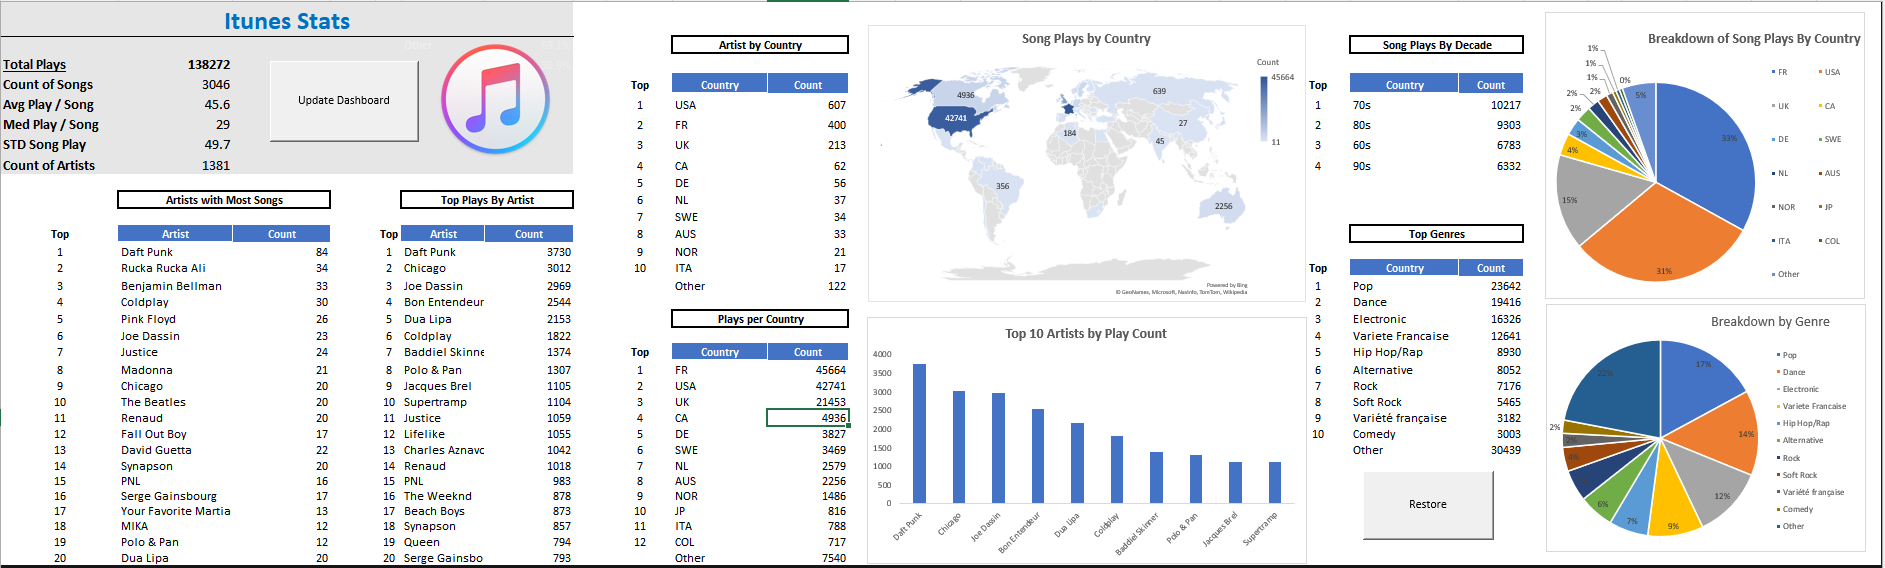

## Introduction:

*Context*: We will use Benjamin Bellman’s Itunes Library to conduct this analysis. All the music
that Ben listens too comes from his Itunes library (not Apple Music) and he currently still uses it. His whole
music library can be found here. These are all the songs that he has kept adding onto in his library
since 2008 (when he was 13). There are a couple of important of disclosures which will be further
addressed during the analysis:
- The Data comes from Itunes.
- It was exported from Itunes to Excel in csv format.
- A column for country of origin and genre were manually created in Excel.
- Therefore, the Genre and Country columns may have some strange values.
- In addition, the Genre’s are subjective. Many songs could be either Electronic or Dance.
- Some of the data is incomplete. Not all albums are available, for example.
- Ben got a new macbook back in 2013. This means three things:

<br> 1) When information was transfered from his old Mac to the New one, the play count of songs before 2013 was erased.

<br> 2) Another consequence is that a large majority of songs prior to 2013 were added on 9/4/2013.This is why this day will record the most added songs and why overall, many songs were
added in 2013.

<br> 3) Some songs were sadly lost, erased or deleted (~100).

# I. Data Cleaning

In [1]:
## We import packages that will be needed.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from datetime import datetime as dt

import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot 

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error as mse, r2_score


from io import StringIO  
from IPython.display import Image  
import pydotplus
import graphviz

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', None)
sns.set()

In [2]:
## Let's load our data and preview it.
music = pd.read_csv('.\Apple_Music_Raw_Data.csv', header = None)
music.head()

,0,1,2,3,4,5,6,7
0,Blankets,2:54,Fantompower,4 AM Coding Session,35,"12/2/21, 8:01 AM","12/5/21, 7:20 PM",Lowfi
1,Liquid Larry,1:22,I'm Surf,4 AM Coding Session,35,"12/2/21, 8:00 AM","12/5/21, 7:17 PM",Lowfi
2,Epilogue (Original Mix),0:50,Mell-o,4 AM Coding Session,36,"12/2/21, 8:00 AM","12/5/21, 7:16 PM",Lowfi
3,Beautiful escape,3:41,Hoogway,4 AM Coding Session,36,"12/2/21, 8:00 AM","12/5/21, 7:15 PM",Lowfi
4,Waiting For Your Call,3:05,Jordy Chandra,4 AM Coding Session,36,"12/2/21, 8:00 AM","12/5/21, 7:12 PM",Lowfi


In [3]:
## We have no columns, let's rename them.
columns = ['song_title','duration','music_artist','album','plays','date_added','last_played','genre']
music.columns = columns
music.head()

,song_title,duration,music_artist,album,plays,date_added,last_played,genre
0,Blankets,2:54,Fantompower,4 AM Coding Session,35,"12/2/21, 8:01 AM","12/5/21, 7:20 PM",Lowfi
1,Liquid Larry,1:22,I'm Surf,4 AM Coding Session,35,"12/2/21, 8:00 AM","12/5/21, 7:17 PM",Lowfi
2,Epilogue (Original Mix),0:50,Mell-o,4 AM Coding Session,36,"12/2/21, 8:00 AM","12/5/21, 7:16 PM",Lowfi
3,Beautiful escape,3:41,Hoogway,4 AM Coding Session,36,"12/2/21, 8:00 AM","12/5/21, 7:15 PM",Lowfi
4,Waiting For Your Call,3:05,Jordy Chandra,4 AM Coding Session,36,"12/2/21, 8:00 AM","12/5/21, 7:12 PM",Lowfi


In [4]:
## Let's look at the info. 
music.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3006 entries, 0 to 3005
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   song_title    3006 non-null   object
 1   duration      3006 non-null   object
 2   music_artist  3006 non-null   object
 3   album         1625 non-null   object
 4   plays         2991 non-null   object
 5   date_added    3006 non-null   object
 6   last_played   2991 non-null   object
 7   genre         3006 non-null   object
dtypes: object(8)
memory usage: 188.0+ KB


This is how Apple_Music spits out music. However, being passionate about my music, I manually added the countries for all artists in the dataset. Let's see what this looks like.

In [5]:
## We load and preview the new data. 
music = pd.read_csv('.\Music_Data_Countries.csv')
music.head()

,Song ID,Song Title,Lenght,Country,Artist,Album,Plays,Date Added,Last Played,Genre,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,1,The Set-Up,4:14,USA,Moodyman,NaN,30.0,"11/22/21, 7:56 AM","11/23/21, 10:29 AM",Electronic,NaN,NaN,NaN,NaN
1,2,Italo Disco,6:56,FR,Lifelike,NaN,53.0,"11/22/21, 7:54 AM","11/23/21, 7:59 PM",Dance,NaN,NaN,NaN,NaN
2,3,Horizon (Japan bonus track),4:25,FR,Daft Punk,Random Access Memories,67.0,"11/21/21, 11:16 AM","11/23/21, 3:20 PM",Alternative,NaN,NaN,NaN,NaN
3,4,Aerodynamic (Daft Punk Remix),6:11,FR,Daft Punk,NaN,44.0,"11/21/21, 11:14 AM","11/23/21, 7:30 PM",Dance,NaN,NaN,NaN,NaN
4,5,Metamodernity,2:43,USA,Vansire,NaN,64.0,"11/18/21, 5:09 PM","11/23/21, 6:10 PM",Alternative,NaN,NaN,NaN,NaN


In [6]:
##We data a look at the columns 
music.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2979 entries, 0 to 2978
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Song ID       2979 non-null   int64  
 1   Song Title    2979 non-null   object 
 2   Lenght        2979 non-null   object 
 3   Country       2979 non-null   object 
 4   Artist        2979 non-null   object 
 5   Album         1608 non-null   object 
 6   Plays         2964 non-null   float64
 7   Date Added    2979 non-null   object 
 8   Last  Played  2964 non-null   object 
 9   Genre         2979 non-null   object 
 10  Unnamed: 10   0 non-null      float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   0 non-null      float64
 13  Unnamed: 13   0 non-null      float64
dtypes: float64(5), int64(1), object(8)
memory usage: 326.0+ KB


In [7]:
## We drop columns which we do not need and contain no values. 
music = music.drop(columns=['Unnamed: 10','Unnamed: 11','Unnamed: 12','Unnamed: 13'])
music.head()

,Song ID,Song Title,Lenght,Country,Artist,Album,Plays,Date Added,Last Played,Genre
0,1,The Set-Up,4:14,USA,Moodyman,NaN,30.0,"11/22/21, 7:56 AM","11/23/21, 10:29 AM",Electronic
1,2,Italo Disco,6:56,FR,Lifelike,NaN,53.0,"11/22/21, 7:54 AM","11/23/21, 7:59 PM",Dance
2,3,Horizon (Japan bonus track),4:25,FR,Daft Punk,Random Access Memories,67.0,"11/21/21, 11:16 AM","11/23/21, 3:20 PM",Alternative
3,4,Aerodynamic (Daft Punk Remix),6:11,FR,Daft Punk,NaN,44.0,"11/21/21, 11:14 AM","11/23/21, 7:30 PM",Dance
4,5,Metamodernity,2:43,USA,Vansire,NaN,64.0,"11/18/21, 5:09 PM","11/23/21, 6:10 PM",Alternative


In [8]:
## And rename the ones we do. 
columns = ['song_id','title','time','country','artist','album','plays','date_added','last_played','genre']
music.columns = columns
music.head()

,song_id,title,time,country,artist,album,plays,date_added,last_played,genre
0,1,The Set-Up,4:14,USA,Moodyman,NaN,30.0,"11/22/21, 7:56 AM","11/23/21, 10:29 AM",Electronic
1,2,Italo Disco,6:56,FR,Lifelike,NaN,53.0,"11/22/21, 7:54 AM","11/23/21, 7:59 PM",Dance
2,3,Horizon (Japan bonus track),4:25,FR,Daft Punk,Random Access Memories,67.0,"11/21/21, 11:16 AM","11/23/21, 3:20 PM",Alternative
3,4,Aerodynamic (Daft Punk Remix),6:11,FR,Daft Punk,NaN,44.0,"11/21/21, 11:14 AM","11/23/21, 7:30 PM",Dance
4,5,Metamodernity,2:43,USA,Vansire,NaN,64.0,"11/18/21, 5:09 PM","11/23/21, 6:10 PM",Alternative


In [9]:
## Let's take a look again/
music.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2979 entries, 0 to 2978
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   song_id      2979 non-null   int64  
 1   title        2979 non-null   object 
 2   time         2979 non-null   object 
 3   country      2979 non-null   object 
 4   artist       2979 non-null   object 
 5   album        1608 non-null   object 
 6   plays        2964 non-null   float64
 7   date_added   2979 non-null   object 
 8   last_played  2964 non-null   object 
 9   genre        2979 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 232.9+ KB


In [10]:
## We need to convert our date_added and time columnns to datetime. 
music.date_added = pd.to_datetime(music.date_added)
music.time = pd.to_datetime(music.time,format= '%M:%S').apply(lambda x : x - (pd.to_datetime('1900-01-01 00:00:00')))
music['year_added'] = pd.DatetimeIndex(music['date_added']).year.astype(int)
music['month_added'] = pd.DatetimeIndex(music['date_added']).month.astype(int)
music.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2979 entries, 0 to 2978
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   song_id      2979 non-null   int64          
 1   title        2979 non-null   object         
 2   time         2979 non-null   timedelta64[ns]
 3   country      2979 non-null   object         
 4   artist       2979 non-null   object         
 5   album        1608 non-null   object         
 6   plays        2964 non-null   float64        
 7   date_added   2979 non-null   datetime64[ns] 
 8   last_played  2964 non-null   object         
 9   genre        2979 non-null   object         
 10  year_added   2979 non-null   int64          
 11  month_added  2979 non-null   int64          
dtypes: datetime64[ns](1), float64(1), int64(3), object(6), timedelta64[ns](1)
memory usage: 279.4+ KB


In [11]:
## We also create a column to get our song duration in seconds.
music['time_seconds'] = (music['time'].dt.total_seconds())

In [12]:
## Let's preview one more time
music.head()

,song_id,title,time,country,artist,album,plays,date_added,last_played,genre,year_added,month_added,time_seconds
0,1,The Set-Up,0 days 00:04:14,USA,Moodyman,NaN,30.0,2021-11-22 07:56:00,"11/23/21, 10:29 AM",Electronic,2021,11,254.0
1,2,Italo Disco,0 days 00:06:56,FR,Lifelike,NaN,53.0,2021-11-22 07:54:00,"11/23/21, 7:59 PM",Dance,2021,11,416.0
2,3,Horizon (Japan bonus track),0 days 00:04:25,FR,Daft Punk,Random Access Memories,67.0,2021-11-21 11:16:00,"11/23/21, 3:20 PM",Alternative,2021,11,265.0
3,4,Aerodynamic (Daft Punk Remix),0 days 00:06:11,FR,Daft Punk,NaN,44.0,2021-11-21 11:14:00,"11/23/21, 7:30 PM",Dance,2021,11,371.0
4,5,Metamodernity,0 days 00:02:43,USA,Vansire,NaN,64.0,2021-11-18 17:09:00,"11/23/21, 6:10 PM",Alternative,2021,11,163.0


## Let's explore our data and get more information 

In [13]:
## Let's take a look at how many unique genres and artists we have. 
print('Total Different Genres: ' + str(music.genre.nunique()))
print('Total Unique Artists: ' + str(music.artist.nunique()))
print('Total Unique Countries: ' + str(music.country.nunique()))
print('Total Different Albums: ' + str(music.album.nunique()))
print('Total Songs: '+ str(music.song_id.count()))

Total Different Genres: 116
Total Unique Artists: 1563
Total Unique Countries: 44
Total Different Albums: 1088
Total Songs: 2979


In [14]:
## Let's get some summary stats for song length and time: 
music[['time','plays']].describe()

,time,plays
count,2979,2964.000000
mean,0 days 00:03:59.738167170,44.740553
std,0 days 00:01:14.364438869,49.577872
min,0 days 00:00:30,1.000000
25%,0 days 00:03:18,14.000000
50%,0 days 00:03:47,29.000000
75%,0 days 00:04:29,59.000000
max,0 days 00:16:39,1001.000000


In [15]:
## Ok, not all of our songs have a play count. So we need to put 0 for all of them. 
music.plays.fillna(0, inplace =True)
print("The number of songs that haven't been played: " + str(music[music['plays']== 0]['title'].count()))

The number of songs that haven't been played: 15


In [16]:
## Let's look one more time. 
music[['time','plays']].describe()

,time,plays
count,2979,2979.000000
mean,0 days 00:03:59.738167170,44.515274
std,0 days 00:01:14.364438869,49.554178
min,0 days 00:00:30,0.000000
25%,0 days 00:03:18,14.000000
50%,0 days 00:03:47,28.000000
75%,0 days 00:04:29,58.000000
max,0 days 00:16:39,1001.000000


# II. Data Wrangling: 


In [17]:
## We create our by country_dataframe. 
by_country = music.groupby('country').agg(artist = ('artist','nunique'),
                                          plays = ('plays','sum'),
                                          songs = ('title','nunique'),
                                          average_play = ('plays', np.mean)
                                          ).sort_values('plays', ascending = False).reset_index()                                    
by_country.head()

,country,artist,plays,songs,average_play
0,FR,387,44497.0,856,51.441618
1,USA,605,42009.0,1085,37.982821
2,UK,211,21372.0,438,47.919283
3,CA,59,4654.0,103,45.184466
4,DE,57,3862.0,88,43.393258


In [18]:
## We had a lot of genre's, so we condensed them in a couple of categories before create the genre dataframe. 
music.replace(
    {'French Pop': "Foreign", "Alternative et rock latino":"Foreign", "Alternativo & Rock Latino": "Foreign", 
     "Arabic": "Foreign", "Brazilian": "Foreign", "Chanson": "Foreign", "Kpop": "Foreign", "Latin":"Foreign", 
     "Latino": "Foreign", "Musique francophone": "Foreign", "Musique pour enfants": "Foreign", 
     "Musiques du monde": "Foreign", "Variété française": "Foreign", "Variete Francaise": "Foreign", 
     "World": "Foreign", "Vari_t_ fran_aise": "Foreign",'K-Pop':"Foreign"}, inplace=True)

music.replace(
    {'Club': "EDM", "Dance": "EDM", "Dance;Trance;Tech": "EDM","Deep House": "EDM", "Disco": "EDM", 
     "Dubstep": "EDM", "EDM": "EDM", "Electronic": "EDM", "Electronic;House;Dance;Techno": "EDM", 
     "Electronic;Jazz;Dance": "EDM", "Electronica": "EDM", "Electronica/Dance": "EDM","Electronique": "EDM", 
     "Electroswing": "EDM", "Fitness & Workout": "EDM","Future House": "EDM", "G-House": "EDM", "House": "EDM", 
     "House;Electronic;Dance;Club": "EDM", "Indie Dance": "EDM", "Kygo": "EDM", "Melodic Deep House": "EDM", 
     "Nu Disco / Funk": "EDM", "Trance": "EDM", "Vaporwave":"EDM", "#dance":"EDM"}, inplace=True)

music.replace(
    {'Rock': "Rock", "Classic Rock": "Rock", "Classic Rock;Rock;Pop": "Rock", "Hard Rock": "Rock", "Metal": "Rock", 
     "Nu-Metal": "Rock", "PopRock": "Rock", "Pop;Oldies;Classic Rock": "Rock", "Psychedlic Rock": "Rock", "Punk": "Rock", 
     "Punk Rock": "Rock", "Rock": "Rock", "Rock/Pop": "Rock","Rock;Alternative": "Rock", "Soft Rock": "Rock", 
     "AlternRock": "Rock","Pop Rock":"Rock","Rock;Electronic":"Rock"},inplace=True)

music.replace(
    {'Alternative Rap': "Hip-Hop", "Hip Hop/Rap": "Hip-Hop","Hip-Hop": "Hip-Hop", "Hip-Hop/Rap": "Hip-Hop", 
    "Hip-Hop;Rap": "Hip-Hop","Hip-hop/Rap": "Hip-Hop", "RAP FR / OTHERS": "Hip-Hop", "Rap": "Hip-Hop","Rap & Hip-Hop": 
    "Hip-Hop", "Reggaeton y Hip-Hop": "Hip-Hop","Rap/R&B":"Hip-Hop"}, inplace=True)

music.replace(
    {'Alternative': "Alternative", "Alternative & Punk":"Alternative", "Alternative Punk": "Alternative", 
    "Grunge": "Alternative","Tropical_Garage": "Alternative","Indie":"Alternative"}, inplace=True)

music.replace(
    {'Britpop': "Pop", "Europop": "Pop", "Pop": "Pop", "Pop Latino": "Pop", "R & B": "Pop", "R&B": "Pop", 
     "R&B/Soul": "Pop", "Pop":"Pop"}, inplace=True)

music.replace(
    {'Comedy': "Comedy", "Karaoke": "Comedy", "Humor": "Comedy"}, inplace=True)

music.replace({'Bandes originales': "Soundtrack", "Soundtrack":"Soundtrack"}, inplace=True)

music.replace({'mashup': "Mashup"}, inplace=True)

music.replace(
    {'Ambient': "Other", "Funk":"Other","Bass": "Other", "Blues": "Other","Classical": "Other", 
    "Classical Music - Chamber Music ": "Other","Country": "Other", "Easy Listening": "Other", 
    "Folk": "Other", "General Jazz": "Other", "Gospel": "Other", "Holiday": "Other", "Instrumental":"Other", 
    "Jazz": "Other", "Jazz;Swing;Easy Listening": "Other", "Laser Funk":"Other", "Musique religieuse": "Other", 
    "New Age": "Other", "Oldies":"Other", "Other": "Other", "Reggae": "Other", "Singer/Songwriter": "Other",
    "Soul and R&B": "Other", "Summertime All The Time": "Other", "Summertime, All The Time": "Other", 
    "Vocal": "Other", "genre": "Other", "user defined":"Other", "Classical Music - Chamber Music": "Other",
    "Tropical":"Other"}, inplace=True)

by_genre = music.groupby('genre').agg(artist = ('artist','nunique'),
                                          plays = ('plays','sum'),
                                          songs = ('title','nunique'),
                                          average_play = ('plays', np.mean),
                                          median_play =('plays', np.median)
                                          ).sort_values('plays', ascending = False).reset_index()
                                   
by_genre.head()

,genre,artist,plays,songs,average_play,median_play
0,EDM,502,40556.0,794,50.380124,34.0
1,Pop,368,27140.0,586,45.844595,29.0
2,Foreign,168,19712.0,340,57.637427,39.0
3,Rock,201,14599.0,338,42.562682,22.0
4,Hip-Hop,186,10356.0,303,33.514563,21.0


In [19]:
## Now by year
by_year = music.groupby('year_added').agg(artist = ('artist','nunique'),
                                          plays = ('plays','sum'),
                                          songs = ('title','nunique'),
                                          average_play = ('plays', np.mean)
                                          ).sort_values('plays', ascending = False).reset_index()
                                   
by_year.head(3)

,year_added,artist,plays,songs,average_play
0,2021,221,20673.0,260,79.206897
1,2013,511,17469.0,863,20.033257
2,2017,98,14177.0,165,85.921212


In [20]:
# Now by Month
by_month = music.groupby('month_added').agg(artist = ('artist','nunique'),
                                          plays = ('plays','sum'),
                                          songs = ('title','nunique'),
                                          average_play = ('plays', np.mean)
                                          ).sort_values('plays', ascending = False).reset_index()
by_month.head(3)

,month_added,artist,plays,songs,average_play
0,9,623,29616.0,1023,28.614493
1,7,128,11315.0,163,69.417178
2,3,176,11031.0,207,53.289855


# III. Exploratory Data Analysis (EDA)

In [21]:
## Let's look at the top songs:
music.plays.sort_values(ascending=False).head(10)

603     1001.0
805      529.0
602      371.0
862      316.0
298      306.0
620      301.0
561      298.0
2583     293.0
768      290.0
350      261.0
Name: plays, dtype: float64

Ok, the top song is an outlier. The three most played songs seem to be very high, so we will not remove them, but change the x axis to better visualize the distribution. 

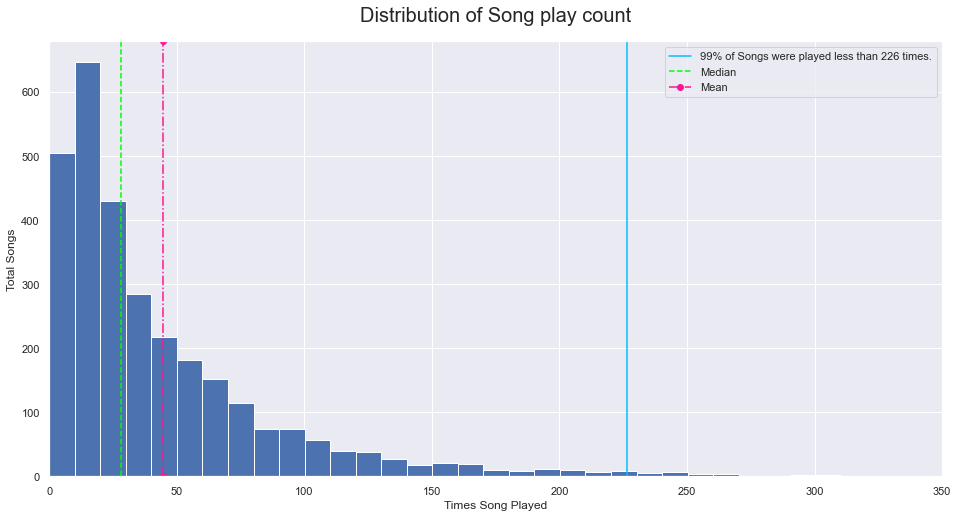

In [22]:
## Let's plot the distribution of plays
percentile_99 = np.percentile(music.plays,99)
median = np.median(music.plays)
mean = np.mean(music.plays)

_ = plt.figure(figsize=(16,8))
_ = music.plays.hist(bins=100)
_ = plt.xlim([0,350])
_ = plt.axvline(percentile_99, c ='deepskyblue', label = '99% of Songs were played less than ' +str(int(round(percentile_99,0)))+ ' times.')
_ = plt.axvline(median, c='lime', label = 'Median', linestyle ='--')
_ = plt.axvline(mean, c ='deeppink', marker ='o',linestyle ='-.',label='Mean')
_ = plt.xlabel('Times Song Played', fontsize =12)
_ = plt.ylabel('Total Songs', fontsize =12)
_ = plt.title('Distribution of Song play count', fontsize =20, pad =20)
_ = plt.legend()

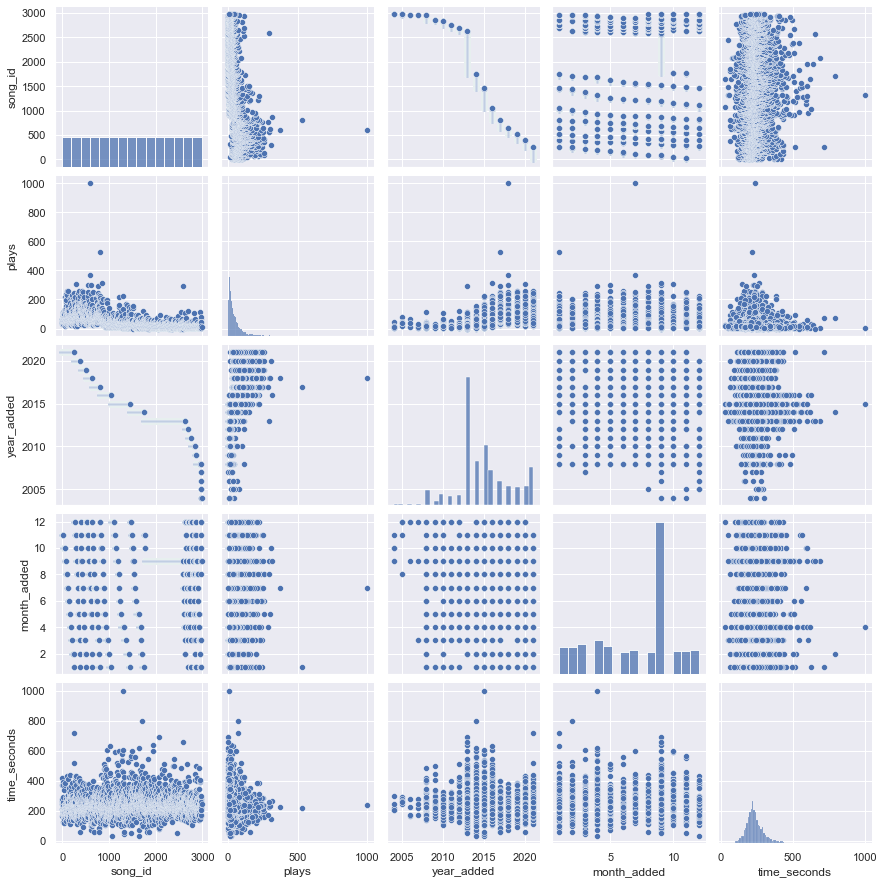

In [23]:
## Let's create a pairplot
sns.pairplot(music)
plt.show()

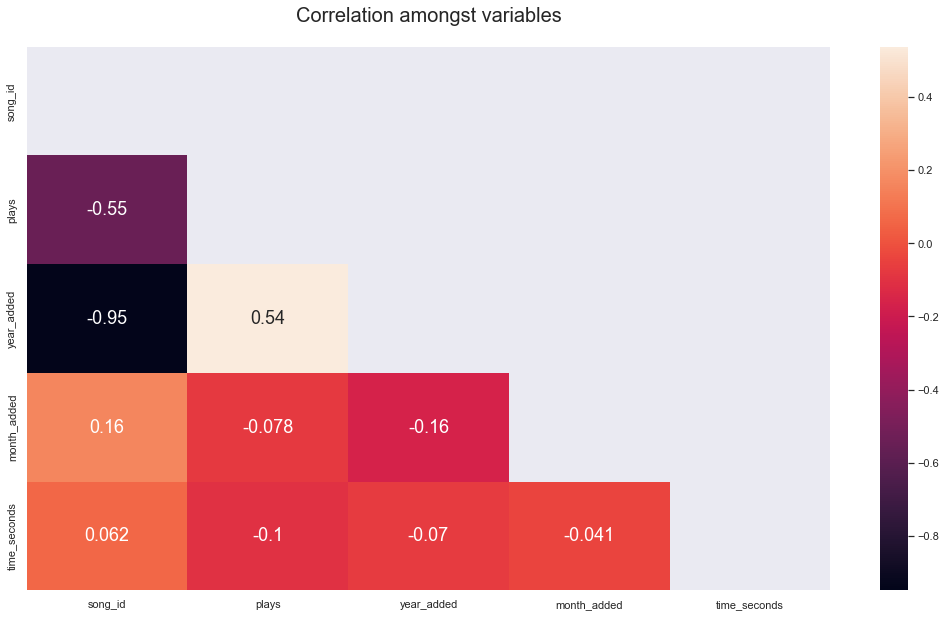

In [24]:
## We can create a heatmap
plt.figure(figsize=(18,10))
sns.heatmap(music.corr(), annot =True,annot_kws = {'size':18}, mask = np.triu(music.corr()) )
plt.title('Correlation amongst variables', pad =25, fontsize =20)
plt.show()

# III. Modeling

## Modelling with Linear Regression

### 1. Simple Linear Regression:

In [25]:
## Let's preview our music data again
music.head(2)

,song_id,title,time,country,artist,album,plays,date_added,last_played,genre,year_added,month_added,time_seconds
0,1,The Set-Up,0 days 00:04:14,USA,Moodyman,NaN,30.0,2021-11-22 07:56:00,"11/23/21, 10:29 AM",EDM,2021,11,254.0
1,2,Italo Disco,0 days 00:06:56,FR,Lifelike,NaN,53.0,2021-11-22 07:54:00,"11/23/21, 7:59 PM",EDM,2021,11,416.0


In [26]:
## Let's see the columns
music.columns

Index(['song_id', 'title', 'time', 'country', 'artist', 'album', 'plays',
       'date_added', 'last_played', 'genre', 'year_added', 'month_added',
       'time_seconds'],
      dtype='object')

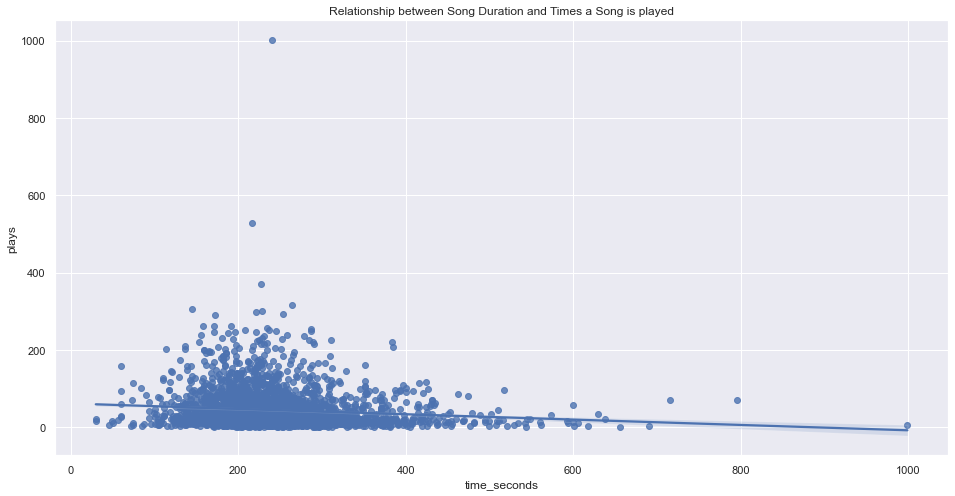

In [27]:
# Let's create a scatterplot to plot how much a song is played depending on its length
_ = plt.figure(figsize=(16,8))
_ = sns.regplot(x='time_seconds',y='plays', data=music)
_ = plt.title('Relationship between Song Duration and Times a Song is played')
plt.show()

In [28]:
## We see a slight negative correlation. Let's proceed to the Linear Regression by define our variables. 
X = music[['time_seconds']]
y = music[['plays']]

In [29]:
## We split our data in training and testing. 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.25)

In [30]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2234, 1) (2234, 1)
(745, 1) (745, 1)


In [31]:
## We fit our model and get R squared of 0.01: 
rModel = LinearRegression(normalize = True)
rModel.fit(X_train, y_train)
print(rModel.score(X_train,y_train))

0.01138536726199546


Only 1 % of the variance in our data is explained by time_seconds. This is not a great result...

## 2. Multiple Linear Regression

Let's do a multiple linear regression with a couple of variables. 
- **Country of Origin**
- **Song Genre**
- **Year Added**
- **Month Added**
- **Time Seconds**

In [32]:
## We pick our variables and store them in a list features which will become our independent variables X. 
## We will only looking at songs below 200 plays.
features = ['country', 'genre', 'year_added', 'month_added','time_seconds']
music2 = music[music.plays <200]
X = music2[features]
X = sm.add_constant(X)
y = music2["plays"]

In [33]:
## We have to use one hot encoding with pd.get_dummies to pass our variables in the proper format.
X = pd.get_dummies(X, columns = ['country', 'genre','year_added','month_added'], drop_first = True)
X.head()

,const,time_seconds,country_AUT,country_BB,country_BE,country_BRA,country_BY,country_CA,country_CH,country_CL,country_CN,country_COL,country_DE,country_DK,country_DZ,country_EE,country_EGY,country_ESP,country_FIN,country_FR,country_IE,country_IL,country_ITA,country_JM,country_JP,country_LT,country_MEX,country_MOL,country_NL,country_NOR,country_PAN,country_PT,country_RO,country_RUS,country_SK,country_SLO,country_SR,country_SWE,country_TUR,country_UK,country_USA,country_VEN,country_XK,country_ZA,genre_Comedy,genre_EDM,genre_Foreign,genre_Hip-Hop,genre_Mashup,genre_Other,genre_Pop,genre_Rock,genre_Soundtrack,year_added_2005,year_added_2006,year_added_2007,year_added_2008,year_added_2009,year_added_2010,year_added_2011,year_added_2012,year_added_2013,year_added_2014,year_added_2015,year_added_2016,year_added_2017,year_added_2018,year_added_2019,year_added_2020,year_added_2021,month_added_2,month_added_3,month_added_4,month_added_5,month_added_6,month_added_7,month_added_8,month_added_9,month_added_10,month_added_11,month_added_12
0,1.0,254.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,1.0,416.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,1.0,265.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,1.0,371.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,1.0,163.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [34]:
## We create training and testing data
X_train, X_test , y_train, y_test = train_test_split(X,y, test_size =0.25, random_state = 42)
print(X_train.shape, y_train.shape,X_test.shape, y_test.shape)

(2193, 81) (2193,) (732, 81) (732,)


In [35]:
## We fit our model to the linear regression and predict y_test
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
y_pred_lin = lin_reg.predict(X_test)

In [36]:
## We plot the results of our predictions vs the actual plays.
print('R Squared - Multiple Linear Regression: ' + str(round(r2_score(y_test,y_pred_lin),3)))

R Squared - Multiple Linear Regression: 0.526


In [37]:
## We can also perform this with statsmodels Linear Regression to get additional information
'''
x_test = sm.add_constant(X_test)
rModel = sm.OLS(y_test, x_test)
result = rModel.fit()
result.summary()
'''

'\nx_test = sm.add_constant(X_test)\nrModel = sm.OLS(y_test, x_test)\nresult = rModel.fit()\nresult.summary()\n'

Surprisingly accurate for features that appear random... Let's plot this.

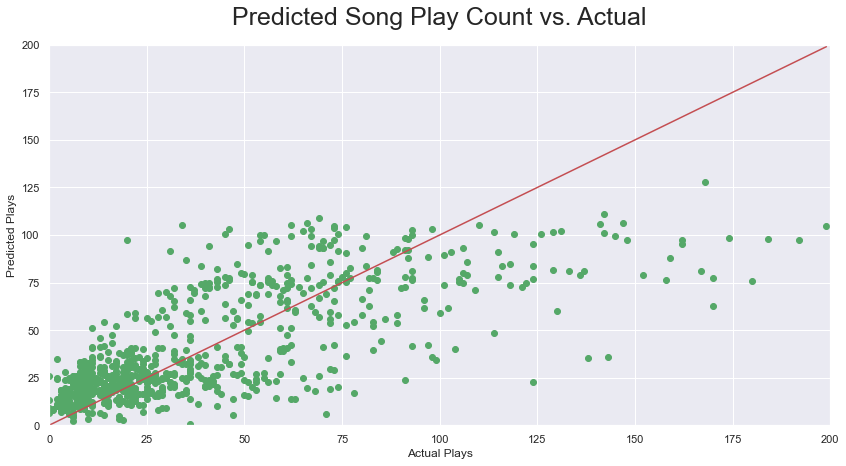

In [38]:
## We plot our predicted values from our Actual Plays
plt.figure(figsize=(14,7))
plt.scatter(y_test, y_pred_lin, c='g')

# Add a line for perfect correlation
plt.plot([x for x in range(0,200)],[x for x in range(0,200)], color='r')

# Label it nicely
plt.xlabel('Actual Plays')
plt.ylabel('Predicted Plays')
plt.title('Predicted Song Play Count vs. Actual', fontsize=25, pad=20)
plt.xlim([0,200])
plt.ylim([0,200])
plt.show()

In [39]:
## This is used as a double check - Uncomment to make sure value correspond 

#print(np.array(y_test)[0:10])
#print(y_pred_lin[0:10])
#differences.head(10)

In [40]:
## We can take a look at our predictions and see how the compare to our actuals. 
differences = pd.DataFrame({'Predicted':y_pred_lin,'Actuals': np.array(y_test)})
differences.sample(10)

,Predicted,Actuals
500,57.252063,54.0
378,16.564024,7.0
584,18.348542,35.0
52,77.306944,56.0
338,22.246501,41.0
585,76.007393,57.0
330,80.819902,93.0
92,17.395646,5.0
60,25.300772,23.0
445,19.175097,29.0


In [41]:
## We can see on average 
def average_error(predictions, actuals):
    return abs((predictions - actuals)).mean()

print('Mean of Song Plays: ' + str(round(music.plays.mean(),2)))
print('R Squared - Multiple Regression: ' + str(round(r2_score(y_test,y_pred_lin),3)))
print('MSE: '+ str(round(mse(differences["Actuals"],differences["Predicted"]),3)))
#print('MSE - double_check: '+ str(round(mse(y_test,y_pred_lin),3)))
print('RMSE: ' +str(round(mse(y_test, y_pred_lin, squared =False),2)))
print('Average Prediction Error: ' + str(round(average_error(differences["Predicted"], differences["Actuals"]),2)))

Mean of Song Plays: 44.52
R Squared - Multiple Regression: 0.526
MSE: 641.346
RMSE: 25.32
Average Prediction Error: 18.29


## Decision Tree:
- Every model has parameters that have to be tuned to optimize model performance. In a decision tree, one of the most important parameters is the **max_depth.**
- For our **Decision Tree model**, we are interested in finding the optimal max_depth which is how many decision the tree should make to minimize the MSE on the testing data (since this is the unseen data that the model has not been trained on).
- We will perform greater parameter tuning with GridSearchCV with the following model, the **Random Forest Regressor** which is an ensemble method that is more efficient than the decision tree. 
- The following code below will retrieve the optimal max_depth and graph it for us. 

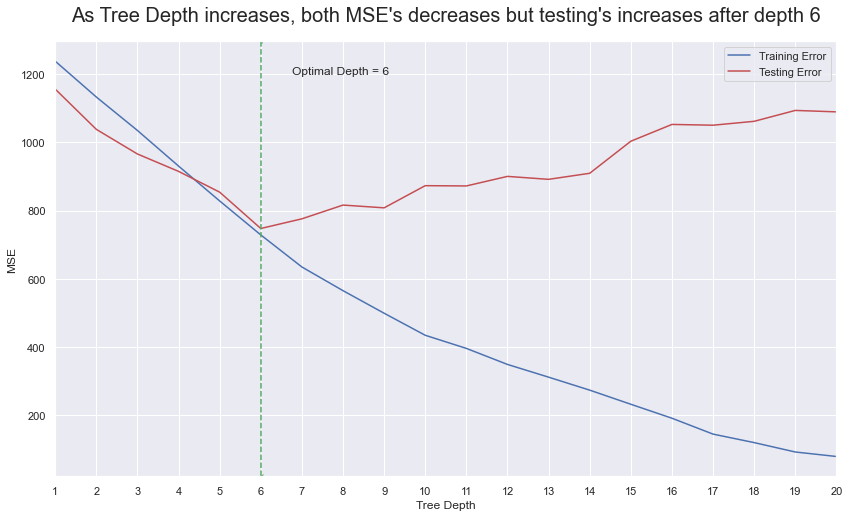

In [42]:
## PLOTTING THE TRAINING AND TESTING MSEs ACCROSS DIFFERENT MAX_DEPTH PARAMETERS.

## We append the the MSEs for each max_depth testing for the training test.
max_depths = range(1,21)
training_error = []
for max_depth in max_depths:
    model_1 = DecisionTreeRegressor(max_depth = max_depth)
    model_1.fit(X,y)
    training_error.append(mse(y_train,model_1.predict(X_train)))

## We append the MSEs for each max_depth tested for the testing test.
testing_error=[]
for max_depth in max_depths:
    model_2 = DecisionTreeRegressor(max_depth = max_depth)
    model_2.fit(X_train,y_train)
    testing_error.append(mse(y_test,model_2.predict(X_test)))

## Since random_state is not always active, we may get a different result each time. 
## Thus, we store the testing error in errors, create an index, and start the index at 1 since we will use this to return
## the x for the MSE (y intercept) which is the lowest for the testing error. 

errors = list(enumerate(testing_error,1))

## We plot the figures. 
plt.figure(figsize=((14,8)))
plt.plot(max_depths,training_error, c ='b', label='Training Error')
plt.plot(max_depths,testing_error, c ='r',label='Testing Error')
plt.title("As Tree Depth increases, both MSE's decreases but testing's increases after depth " + 
          str(min(errors, key = lambda t: t[1])[0]), fontsize=20, pad=20)

## The axvline changes for each refesh, this code plots a line through the minimum MSE for the testing error.
plt.axvline(x=min(errors, key = lambda t: t[1])[0],c='g',marker='3',linestyle='--')
plt.annotate('Optimal Depth = ' + str(min(errors, key = lambda t: t[1])[0]),
             xy=(min(errors, key = lambda t: t[1])[0] + 0.75,1200) )

## We label the axes and make our graph nice. 
plt.xlabel('Tree Depth')
plt.ylabel('MSE')
plt.xticks(range(0,21))
plt.xlim(1,20)
plt.legend()
plt.show()

## Partially inspired by https://towardsdatascience.com/train-a-regression-model-using-a-decision-tree-70012c22bcc1

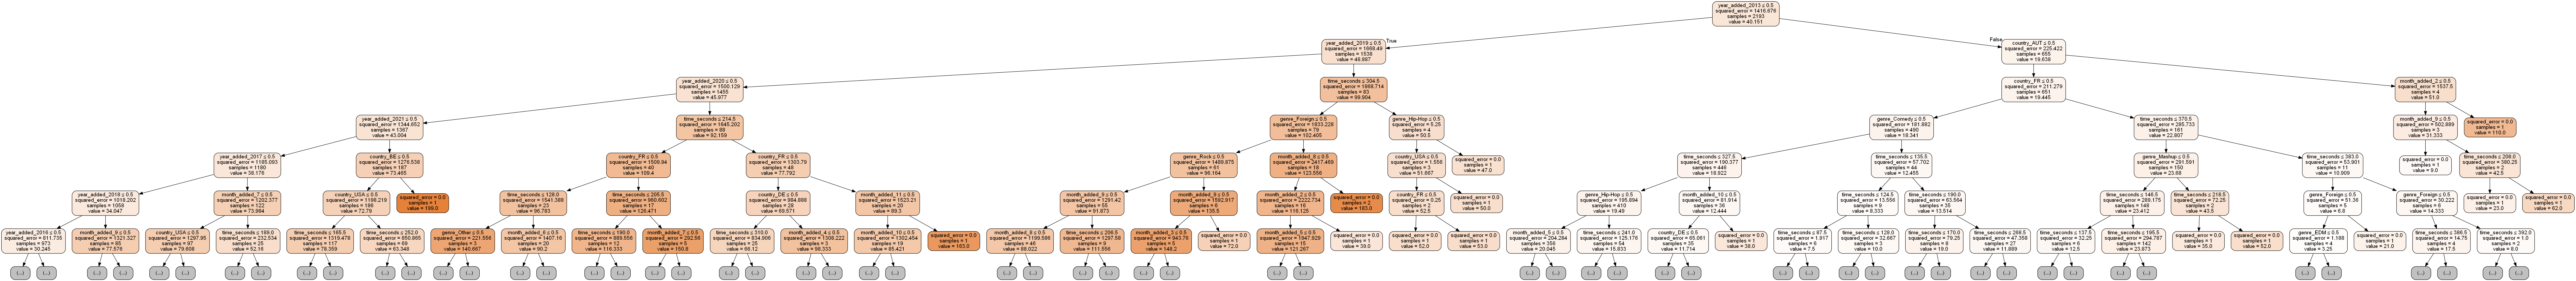

In [43]:
# Now we want to visualize the tree
dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)
dot_data = StringIO()

# We can do so with export_graphviz
export_graphviz(dt, max_depth =min(errors, key = lambda t: t[1])[0], 
            out_file=dot_data,  filled=True, rounded=True,
            special_characters=True, feature_names=X_train.columns,class_names = ["No", "Yes"])

# Alternatively for class_names use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

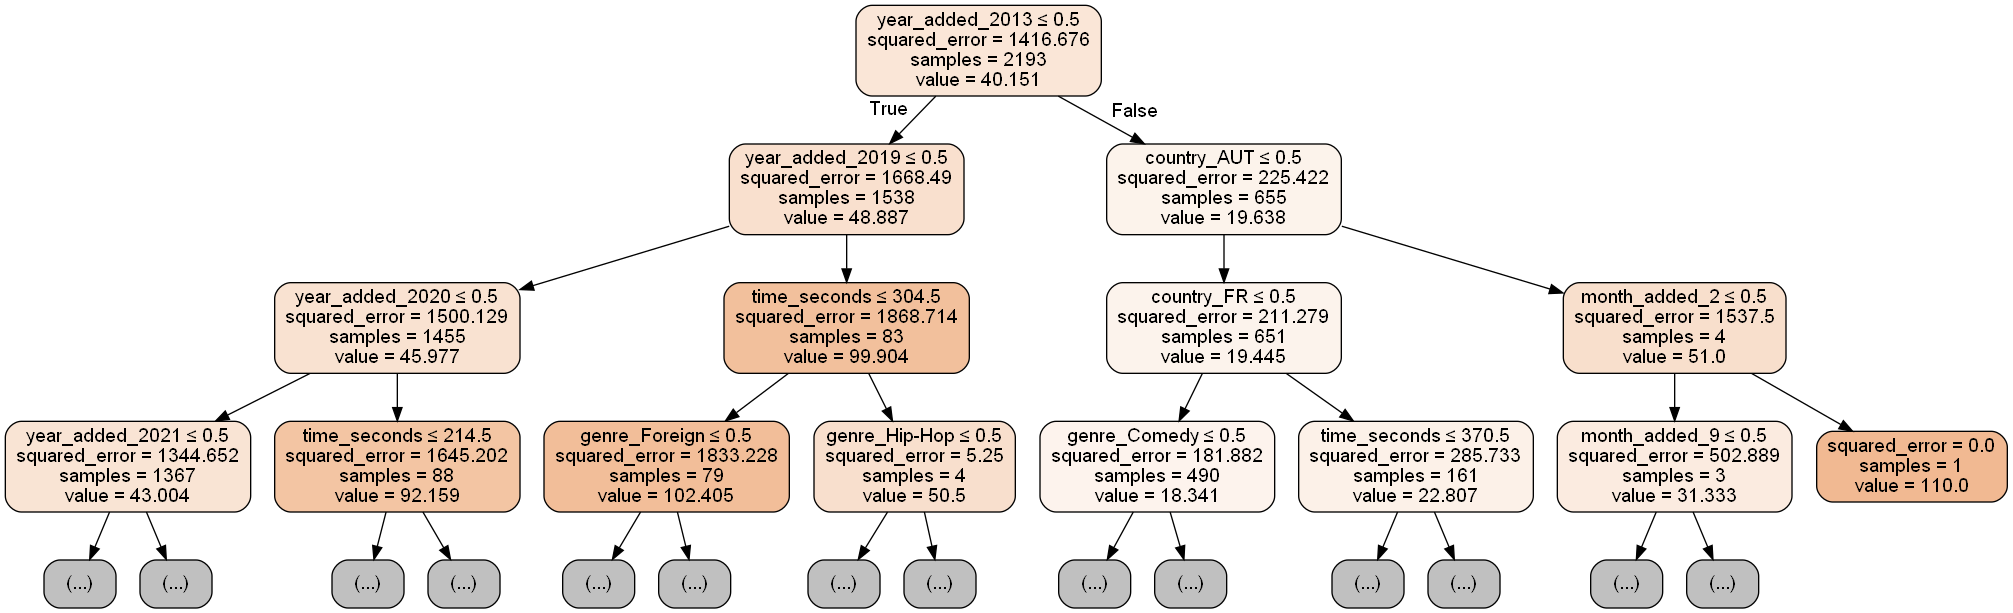

In [44]:
## While it is hard to visualize, we can look at what a tree looks like if it only has 3 branches for example:  
dot_data = StringIO()

# We can do so with export_graphviz
export_graphviz(dt, max_depth = 3, out_file=dot_data,  filled=True, rounded=True,
            special_characters=True, feature_names=X_train.columns,class_names = ["No", "Yes"])

# Alternatively for class_names use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [45]:
## Now back to our tree with the optimal max_depth. Let's print out the metrics: 

dt = DecisionTreeRegressor(max_depth=min(errors, key = lambda t: t[1])[0])
dt.fit(X_train,y_train)
y_pred_dt = dt.predict(X_test)

## We print out the metrics to evaluate the model's effectiveness. 
print('Mean of Song Plays: ' + str(round(music.plays.mean(),2)))
print('R Squared - Decision Tree: ' + str(round(r2_score(y_test,y_pred_dt),3)))
print('MSE: '+ str(round(mse(y_test,y_pred_dt),3)))
print('RMSE: ' +str(round(mse(y_test, y_pred_dt, squared =False),3)))
print('Average Prediction Error: ' + str(round(average_error(y_pred_dt, y_test),3)))

Mean of Song Plays: 44.52
R Squared - Decision Tree: 0.449
MSE: 745.37
RMSE: 27.301
Average Prediction Error: 19.735


## RandomForest Regressor:
- We now switch the Random Forest Regressor which is an ensemble of individual Decision Trees. 

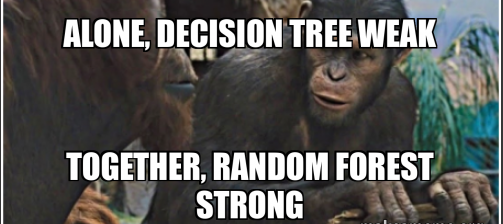

In [46]:
## Now we will try the RandomForest Regressor, an ensemble method of decision trees 


rfg = RandomForestRegressor()
rfg.fit(X_train,y_train)
y_pred = rfg.predict(X_test)
r2_score(y_test,y_pred)

0.5092032068452063

## Conclusion: 

For things that appear somewhat random, this regression model appears to be more reasonable than what is expected. There are a couple of details that were not mentionned which can explain this: 
- **Year_Played**: The year a song was added mattered because 
- **Seconds_Duration**: Since Ben can listen to songs a repeat a lot...
- **Genre**: As seen from dividing the graph, Ben has a couple of favorite Genres. 
- **Country**: An interesting finding is that some countries. There is colinearity which explains this. 

## To be continued: Using Classification Algorithms to try and predict Genres. 

If you have any feedback, please feel free to share it to me at bbellman95@gmail.com